# Analysis of Wikipedia Network
Elliot Williams<br>March 24, 2018<br>Web Scraping w. Prof. Oleinikov

## Background

Before this point, I ran `extractHTML.sh` on the entire set of Wikipedia articles, accessible from the [Internet Archive](https://archive.org/search.php?query=subject%3A%22enwiki%22%20AND%20subject%3A%22data%20dumps%22%20AND%20collection%3A%22wikimediadownloads%22&and[]=subject%3A%22Wikipedia%22), resulting in 54 files representing the adjacency list of the directed Wikipedia network (in which articles are nodes, hyperlinks edges).

## Analyzing the Results

Now, I want to plot the out degree distribution of the Wikipedia network, as well as see some instances of high-degree nodes.

Let's start by figuring out the number of nodes and edges in all the files...

(**Sidenote**: I'm running this on the CS kurtz server -- it takes forever to run on my laptop -- and I'm using [ray](http://ray.readthedocs.io/en/latest/) to run some of my code -- ie `getOutdegs` -- in parallel without having to implement it in parallel myself)

In [118]:
%load_ext rpy2.ipython
ray.init()
import re
import glob
import ray

# Gets list of all adjacency list files
file_list = glob.glob("./link_files/*.dat")

'''
The following function reads in a given adjacency list file and returns
'''
@ray.remote
def getOutdegs(filename):
    f = open(filename)

    # Parses out HTTP links --> just in case any got through the initial search
    # Also, some of the links contain '#' pointers to specific parts of an article 
    # -- let's remove these (both done in one loop for speed purposes)
    lines = [re.sub("#.*", "", line.strip()) for line in f if 
             not re.search("https?:\/\/", line)]

    t_indices = [i for i in range(len(lines)) if re.search(">>>>", lines[i])]

    print("There are {} nodes represented in this file".format(len(t_indices)))
    print("There are {} edges in this file".format(len(lines) - len(t_indices)))
    
    titles   = [re.sub(">>>>", "", lines[i]) for i in t_indices]
    out_degs = [t_indices[i+1] - t_indices[i] - 1 
                for i in range(len(t_indices) - 1)] + [len(lines[t_indices[-1]:])]
    t_outdegs = list(zip(titles, out_degs))
    t_outdegs.sort(key=lambda x : x[1], reverse=True)
    return(t_outdegs)


file_results = ray.get([getOutdegs.remote(filename) for filename in file_list])

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Now that we have our results for each file, let's combine all of the results together into one dataset we can manage

In [116]:
from functools import reduce
t_outdegs = reduce(lambda x,y : x + y, file_results)
t_outdegs.sort(key=lambda x: x[1], reverse=True)

In [21]:
import pandas as pd
titles, outdegs = zip(*t_outdegs)
df = pd.DataFrame({"title": titles, "outdeg":outdegs})

In [22]:
# List of highest outdegree articles
t_outdegs[1:50]

[('Rosters of the top basketball teams in European club competitions', 9068),
 ('List of film director and actor collaborations', 8861),
 ('Timeline of heavy metal and hard rock music', 8333),
 ('List of stage names', 6646),
 ('List of years in jazz', 6490),
 ('List of dialling codes in Germany', 6381),
 ('List of male mixed martial artists', 6300),
 ('List of performances on Top of the Pops', 6249),
 ('List of OMIM disorder codes', 6210),
 ('List of populated places in Bosnia and Herzegovina', 6007),
 ('List of cities, towns and villages in Kerman Province', 5853),
 ('List of protected areas of China', 5842),
 ('List of people from Texas', 5827),
 ('Index of Telangana-related articles', 5778),
 ('Index of Andhra Pradesh-related articles', 5698),
 ('List of cities, towns and villages in Sistan and Baluchestan Province',
  5606),
 ('Alphabetical list of comunes of Italy', 5492),
 ('List of foreign football players in Serbia', 5395),
 ('Index of India-related articles', 5315),
 ('List of

In the first results above, we see a lot of 'List of [X University]' people entries. We could use this as a proxy measure of universities with interesting / noteworthy alumni. Let's try to do this below

In [50]:
uni_t_outdegs = list(filter(lambda x : re.search("List.*(University|College).*(people|alumni)", x[0]), t_outdegs))

In [61]:
uni_t_outdegs[1:20]

[('List of University of Pennsylvania people', 4175),
 ('List of Columbia College people', 3575),
 ('List of University of Toronto people', 2924),
 ('List of Wesleyan University people', 2486),
 ('List of University of Cambridge people', 2351),
 ('List of Duke University people', 2259),
 ('List of Columbia University alumni', 2196),
 ('List of Columbia University alumni and attendees', 2121),
 ('List of Yale University people', 2045),
 ('List of Brown University people', 2040),
 ('List of Stanford University people', 1880),
 ('List of University of Wisconsin–Madison people', 1876),
 ('List of University of Southern California people', 1842),
 ('List of University of California, Los Angeles people', 1737),
 ('List of University of Florida alumni', 1603),
 ('List of University of Minnesota people', 1588),
 ('List of Williams College people', 1570),
 ('List of Northwestern University alumni', 1533),
 ("List of King's College London alumni", 1489)]

Now, let's try to get rid of the "in", "with" and "and" results, which will only serve to double count people.

In [64]:
uni_t_outdegs = list(filter(lambda x : not re.search("( in )|( with )|( and )", x[0]), uni_t_outdegs))
u_titles, u_outdegs = zip(*uni_t_outdegs)
uni_df = pd.DataFrame({"title": u_titles, "outdeg":u_outdegs})

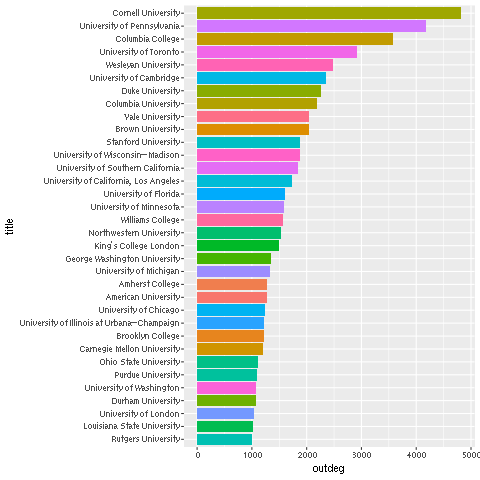

In [90]:
%%R -i uni_df
library(ggplot2)

# I'm making the arbitrary decision to graph all pages with an outdegree > 1000
uni_df <- filter(uni_df, outdeg > 1000) %>%
    mutate(title=gsub("List of ", "", title),
           title=gsub(" (people|alumni)", "", title))
orig_title <- factor(uni_df$title)
    
uni_df$title <- factor(uni_df$title, levels=uni_df$title[order(uni_df$outdeg)])
ggplot(uni_df, aes(x=title, y=outdeg, fill=orig_title)) + geom_bar(stat="identity") +
coord_flip() + theme(legend.position="")

In [119]:
NESCAC_schools = ["Amherst College", "Wesleyan University", "Bowdoin College",
                  "Colby College"  , "Connecticut College", "Hamilton College",
                  "Middlebury College", "Trinity College \(Connecticut\)", "Tufts University",
                  "Williams College"]
nescac_t_outdegs = []
for school in NESCAC_schools:
    nescac_t_outdegs += list(filter(lambda x : re.search("List of " +school, x[0]), uni_t_outdegs))
n_titles, n_outdegs = zip(*nescac_t_outdegs)
nes_df = pd.DataFrame({"title": n_titles, "outdeg":n_outdegs})
nes_df

,outdeg,title
0,1279,List of Amherst College people
1,2486,List of Wesleyan University people
2,625,List of Bowdoin College people
3,2,List of Colby College alumni
4,152,List of Connecticut College alumni
5,408,List of Hamilton College people
6,716,List of Middlebury College alumni
7,583,List of Trinity College (Connecticut) people
8,900,List of Tufts University people
9,1570,List of Williams College people


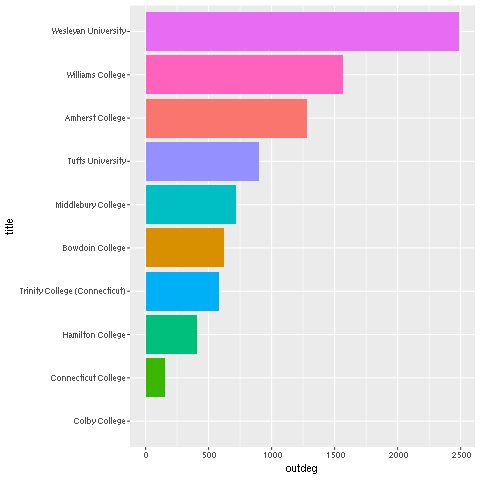

In [93]:
%%R -i nes_df

library(ggplot2)

# I'm making the arbitrary decision to graph all pages with an outdegree > 1000
nes_df <- nes_df %>% mutate(title=gsub("List of ", "", title),
           title=gsub(" (people|alumni)", "", title))
orig_title <- factor(nes_df$title)
    
nes_df$title <- factor(nes_df$title, levels=nes_df$title[order(nes_df$outdeg)])
ggplot(nes_df, aes(x=title, y=outdeg, fill=orig_title)) + geom_bar(stat="identity") +
coord_flip() + theme(legend.position="")

Two things strike me about this figure. First is that of all NESCAC schools with data, Wesleyan appears to have the most Wikipedia links on its alumni page. My three interpretations of this are:

1. That we are a school with cool, noteworthy alumni (my personal favorite interpretation)
2. That we punch above our weight when it comes to editing our Wikipedia page (ie more Wikipedians went to / care about Wesleyan)
3. Michael Roth spends his nights editing our Wikipedia page

The second thing that strikes me is that Colby College is missing outlinks data, despite Colby having an alumni list. 

**TODO**: Check that there aren't errors in the scraping from the database when it comes to pages. Maybe only the abstracts are being scraped... or maybe the pages weren't picked up in that data dump (might be worth trying to scrape from multiple data dumps)

In [120]:
Ivy_Schools = ["Brown University", "Columbia University", "Cornell University",
               "Dartmouth College", "Harvard University", "University of Pennsylvania",
               "Princeton University", "Yale University"]
ivy_t_outdegs = []
for school in Ivy_Schools:
    ivy_t_outdegs += list(filter(lambda x : re.search("(?<=List of) " + school + " (people|alumni)(?=)", x[0]), uni_t_outdegs))
ivy_t_outdegs = list(filter(lambda x : not re.search("\(.*\)", x[0]), ivy_t_outdegs))
ivy_t_outdegs = list(filter(lambda x : not re.search("Columbia University people", x[0]),
                            ivy_t_outdegs))
i_titles, i_outdegs = zip(*ivy_t_outdegs)
ivy_df = pd.DataFrame({"title": i_titles, "outdeg":i_outdegs})

  outdeg                                     title
0   2040           List of Brown University people
1   2196        List of Columbia University alumni
2   4823         List of Cornell University alumni
3     24          List of Dartmouth College alumni
4     17         List of Harvard University people
5   4175 List of University of Pennsylvania people
6    845       List of Princeton University people
7   2045            List of Yale University people


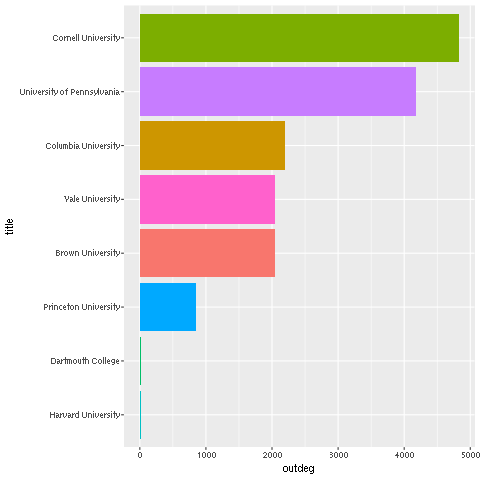

In [112]:
%%R -i ivy_df

print(ivy_df)

library(ggplot2)



# I'm making the arbitrary decision to graph all pages with an outdegree > 1000
ivy_df <- ivy_df %>% mutate(title=gsub("List of ", "", title),
           title=gsub(" (people|alumni)", "", title))
orig_title <- factor(ivy_df$title)
    
ivy_df$title <- factor(ivy_df$title, levels=ivy_df$title[order(ivy_df$outdeg)])
ggplot(ivy_df, aes(x=title, y=outdeg, fill=orig_title)) + geom_bar(stat="identity") +
coord_flip() + theme(legend.position="")

Again, we see that there are very few links for Harvard and Dartmouth, which leads me to conclude that maybe the parser is only dealing with article abstracts...

**TODO:** Investigate this further

We saw before that the nodes with the highest outdegree tend to be lists, indexes and timelines. Let's see what the highest outdegree articles are if we filter these out.

In [29]:
f_t_outdegs = list(filter(lambda x : not re.search("((L|l)ist)|(Index)|(Timeline)", x[0]), t_outdegs))
f_t_outdegs[1:50]

[('2016 in the United States', 3927),
 ('2018 in sports', 3747),
 ('Italian Athletics Championships', 3615),
 ('Culture of the United Kingdom', 3412),
 ('Flora of Lebanon', 3099),
 ('2016 in aviation', 3066),
 ('1979', 2968),
 ('2017 in the United States', 2945),
 ('Agrilus', 2895),
 ('1989', 2855),
 ('1945', 2767),
 ('2015 in aviation', 2737),
 ('The Neptunes production discography', 2713),
 ('1990', 2627),
 ('1991', 2533),
 ('Phyllosticta', 2530),
 ('1992', 2425),
 ('1970', 2415),
 ('1972', 2385),
 ('Plants of the Reserva de la Biosfera Manantlan', 2383),
 ('1986', 2358),
 ('1942', 2345),
 ('Scientific phenomena named after people', 2343),
 ('1988', 2341),
 ('1944', 2341),
 ('1973', 2339),
 ('1980', 2334),
 ('Roads in Malta', 2297),
 ('1993', 2296),
 ('1967', 2296),
 ('1966', 2290),
 ('Chronological summary of the 2016 Summer Olympics', 2289),
 ('1983', 2288),
 ('1977', 2275),
 ('1943', 2244),
 ('History of French animation', 2243),
 ('South East England', 2239),
 ('1969', 2236),
 ("

In [128]:
date_t_outdegs = list(filter(lambda x : re.search("[0-9]{4}", x[0]), f_t_outdegs))
date_t_outdegs = list(filter(lambda x : len(x[0]) == 4, date_t_outdegs))


In [132]:
len(date_t_outdegs)
date_t_outdegs.sort(reverse=True)
date_t_outdegs[1:20]

[('9700', 3),
 ('9630', 4),
 ('9600', 3),
 ('9500', 4),
 ('9300', 2),
 ('9200', 4),
 ('9001', 3),
 ('9000', 15),
 ('8974', 9),
 ('8969', 5),
 ('8800', 3),
 ('8701', 146),
 ('8664', 18),
 ('8600', 3),
 ('8500', 4),
 ('8444', 3),
 ('8200', 3),
 ('8000', 5),
 ('7800', 3)]

In [133]:
# But I only cared about years... so we filter all above 2018 and below 1700
date_t_outdegs = [x for x in date_t_outdegs if int(x[0]) > 1700 and int(x[0])<2019]
len(date_t_outdegs) # Nice, now we only have years

318

In [135]:
d_titles, d_outdegs = zip(*date_t_outdegs)
d_titles = [int(x) for x in d_titles]
date_df = pd.DataFrame({"year": d_titles, "outdeg":d_outdegs})

,outdeg,year
0,174,2018
1,1419,2017
2,1151,2016
3,1135,2015
4,851,2014
5,722,2013
6,639,2012
7,642,2011
8,694,2010
9,648,2009


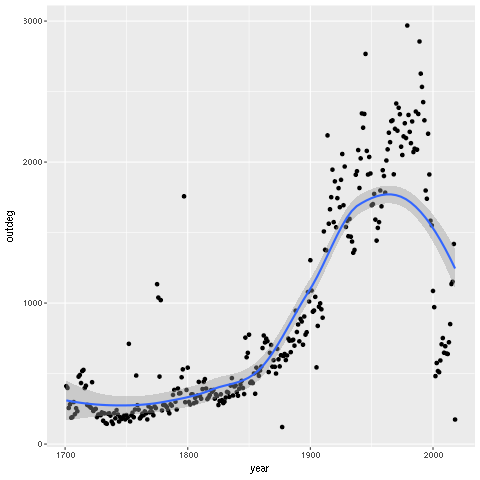

In [150]:
%%R -i date_df

ggplot(date_df, aes(x=year, y=outdeg)) + geom_point() + geom_smooth()

Finally, let's graph our results in R (because I like and know `ggplot` much better than `matplotlib`)

In [16]:
%%capture
%%R -i df -o counts
library(dplyr)
library(ggplot2)

counts <- df %>%
group_by(outdeg) %>%
summarize(n=n()) %>%
arrange(desc(n))

sd_value <- sd(df$outdeg)


counts$cum_n <- cumsum(counts$n)

[1] "The average outdegree of an article on Wikipedia is 22.804"
[1] "The median outdegree of an article on Wikipedia is 11"
[1] "The standard deviation of an article's outdegree on Wikipedia is 53.49"


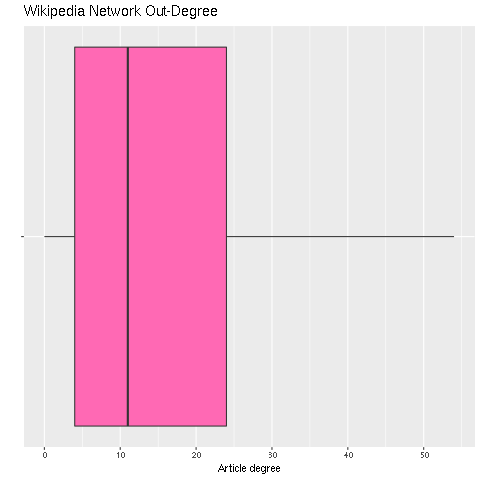

In [19]:
%%R -i counts

mean <- sum(counts$outdeg * counts$n) / sum(counts$n)
mean <- round(mean, digits=3)
print(paste("The average outdegree of an article on Wikipedia is", mean, sep=" "))

median_index <- as.integer(sum(counts$n)/2)
q1_index <- as.integer(sum(counts$n)/4)
q3_index <- as.integer(median_index + q1_index)

q1_value <- min(which(counts$cum_n > q1_index))
median_value <- min(which(counts$cum_n > median_index))
print(paste("The median outdegree of an article on Wikipedia is", median_value)) 
q3_value <- min(which(counts$cum_n > q3_index))

sd_value <- round(sd_value, digits=3)
print(paste("The standard deviation of an article's outdegree on Wikipedia is", sd_value))

desc_df <- data.frame(t(c(min(counts$outdeg), q1_value, median_value, q3_value, 
  1.5*(q3_value-q1_value) + q3_value )))
names(desc_df) <- c("min", "q1", "med", "q3", "max_iqr")

ggplot(desc_df, aes(x = "", middle= median_value, ymin = min,
                    ymax = max_iqr, lower = q1, upper = q3)) + 
    geom_boxplot(stat = "identity", fill="hotpink") + coord_flip() +
    labs(y="Article degree", x="", title="Wikipedia Network Out-Degree")  +
    scale_y_continuous(breaks  = c(0, 10.,20.,30.,40.,50.))


As we can clearly see, the article degree of Wikipedia articles is strongly skewed to the right

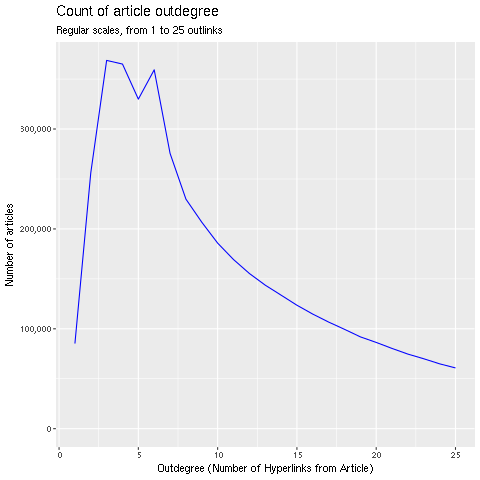

In [7]:
%%R -i counts


print(ggplot(counts, aes(x=outdeg, y=n)) + geom_line(color="blue") +
labs(x="Outdegree (Number of Hyperlinks from Article)",
     y="Number of articles",
     title="Count of article outdegree",
     subtitle="Regular scales, from 1 to 25 outlinks") + xlim(1,25) +
scale_y_continuous(labels = scales::comma))

As we can see, most articles don't have an outdegree of 1 or 2, suggesting the vast majority of articles have more than 2 links associated with them.

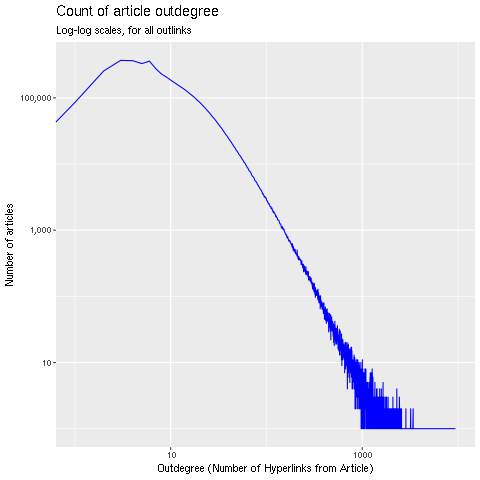

In [8]:
%%R -i counts
ggplot(counts, aes(x=outdeg, y=n)) + geom_line(color="blue") +
labs(x="Outdegree (Number of Hyperlinks from Article)",
     y="Number of articles",
     title="Count of article outdegree",
     subtitle="Log-log scales, for all outlinks") + 
scale_y_continuous(labels = scales::comma, trans="log10") +
scale_x_continuous(trans="log10")

Past 6 links, the number of articles with x links ($x>6$) monotonically decreases, and as you can see, the outdegree (when $\text{outdegree} > 20$ or so) is log-log linear in terms of outdegree, and so can be said to follow a power law distribution with respect to outdegree. Our Wikipedia network can be described as [Scale-Free](https://en.wikipedia.org/wiki/Scale-free_network).

## Indegree Analysis